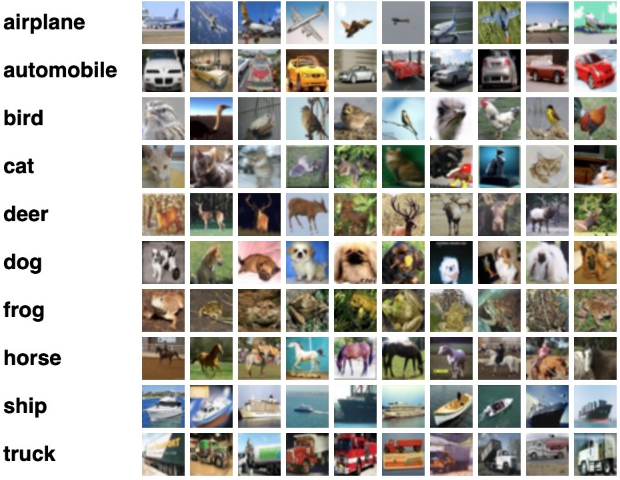

*   Load CIFAR-10 dataset

In [ ]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

*  Set "USE_SEED" to False for your own experiments.

In [ ]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

In [ ]:
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

# You can also use the 'transform' argument to specify transformations to apply to the dataset
# e.g. 'train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=...)'
# See the next steps for applying transformations to a dataset.

100%|██████████| 170498071/170498071 [00:01<00:00, 97872949.13it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

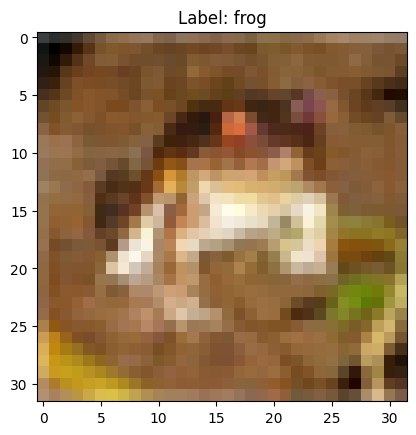

In [ ]:
plt.imshow(img), plt.title("Label: " + classes[label])
plt.show()

*  Data normalization

*  Data normalization

In [ ]:
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.
train_mean = train_data.data.mean(axis=(0,1,2)) / 255
train_std = train_data.data.std(axis=(0,1,2)) / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean}")
print(f"Standard Deviation: {train_std}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


In [ ]:
# Compositions of transformations
# Instead of using PIL images, we will convert them to a Tensor
# which is the data type used by Pytorch.
train_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([  torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(train_mean, train_std),
])

In [ ]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )


In [ ]:
# Let's see if the images are normalized
min_RGB_values = train_data[0][0].amin(dim=(1,2))
print(f"Minimum RGB values : {min_RGB_values}")
max_RGB_values = train_data[0][0].amax(dim=(1,2))
print(f"Maximum RGB values : {max_RGB_values}")

Minimum RGB values : tensor([-1.9892, -1.9802, -1.7070])
Maximum RGB values : tensor([2.0588, 2.0946, 1.8160])


In [ ]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_data) * 0.90)
num_valid_examples = len(train_data) - num_train_examples

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_valid_examples}")

Number of training examples: 45000
Number of validation examples: 5000


In [ ]:
# Create 'Subset' objects
train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_data)}")
print(f"Number validation examples: {len(valid_data)}")

Number training examples: 45000
Number validation examples: 5000


In [ ]:
# Apply test transformations to the validation set
valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
valid_data.dataset.transform = test_transforms

In [ ]:
# Create iterators
BATCH_SIZE =32

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE)

# **MLP**

Let's create a simple MLP network class with three layers with a sigmoid activation function for the hidden layer to classify CIFAR-10 images. The network must inherit from nn.Module and contain a forward method where the input is processed.

---

**Input Layer**: 32 * 32 * 3 = 3072 Units

**Hidden Layer**: 100 Units

**Output Layer**: 10 Units


*  Alternative network definition using a Sequential container. Use this container if input data is fed sequentially to each layer.

In [ ]:
INPUT_DIM = 32*32*3 # 32x32x3 images
OUTPUT_DIM = 10 # 10 classes

In [ ]:
# Inizialize the network
model = MLP(INPUT_DIM, OUTPUT_DIM)
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


*   Let's plot the number of parameters of our network.

*   Count the number of parameters

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad) # Count only parameters that are backpropagated

In [ ]:
print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 308,310 trainable parameters.


* Define Loss and Optimizer

In [ ]:
# Loss
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy

# Put model&criterion (loss) on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [ ]:
# Optim
optimizer = optim.SGD(model.parameters(), lr=3e-3) # Adam optimizer is an alternative optimizer

model = model.to(device)

# Training/Validation/Testing functions

*   Compute accuracy

In [ ]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  accuracy: np.float
    Accuracy
  '''

  # Apply softmax (to convert values into probabilities)
  y_prob = F.softmax(y_pred, dim = -1)
  # Consider class with higher probability
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  # Chech if prediction is correct
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  # Compute accuracy (percentage)
  accuracy = correct.float()/y.shape[0]

  return accuracy

*  Training phase

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Apply train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)

    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

* Validation/Testing phase

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for (x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

*  Model training

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()

    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [ ]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [ ]:
# Test model
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Load best weights
  model.load_state_dict(torch.load(model_name))
  # Evaluate model
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  # Print results
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

*  Confusion matrix and classification report

In [ ]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred


In [ ]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

*  Plot the weights to check if a neuron has learned to look for specific patterns in the input.

In [ ]:
def normalize_image(image):
  image = torch.clamp(image, min = image.min(), max = image.max())
  image = torch.add(image, -image.min()).div_(image.max() - image.min() + 1e-5)
  return image

# **Data augmentation**



In [ ]:
# Apply random rotation + horizontal flipping
# Composition of transformations
train_transforms = torchvision.transforms.Compose([
                                                    torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.RandomRotation(15),
                                                   torchvision.transforms.RandomHorizontalFlip(p=0.6),
                                                    torchvision.transforms.ColorJitter(),
                                                    torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.3, 3.0)),
                                                    torchvision.transforms.RandomVerticalFlip(p=0.6),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(train_mean, train_std)

])

In [ ]:
train_data.dataset.transform = train_transforms

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

# Create new model
model = MLP(INPUT_DIM, OUTPUT_DIM)

optimizer = optim.SGD(model.parameters(), lr=5e-3)
model = model.to(device)

In [ ]:
num_classes = 10

    # Import ResNet50 model pretrained on ImageNet
model2 = models.resnet50(pretrained=True)
print("Network before modifying conv1:")
print(model2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Network before modifying conv1:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [ ]:
model2.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

In [ ]:
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, num_classes)
#for param in model2.parameters():
    #if isinstance(param, nn.Conv2d):
       # param.requires_grad = False


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.009, momentum=0.9, weight_decay=5e-4)

In [ ]:
for param in model2.parameters():
  if param.requires_grad ==True:
    print(1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1



Epoch: 1/32 -- Epoch Time: 138.96 s
---------------------------------
Train -- Loss: 0.611, Acc: 78.64%
Val -- Loss: 0.695, Acc: 75.86%

Epoch: 2/32 -- Epoch Time: 138.34 s
---------------------------------
Train -- Loss: 0.598, Acc: 79.30%
Val -- Loss: 0.638, Acc: 77.05%

Epoch: 3/32 -- Epoch Time: 137.72 s
---------------------------------
Train -- Loss: 0.584, Acc: 79.67%
Val -- Loss: 0.654, Acc: 77.49%

Epoch: 4/32 -- Epoch Time: 137.98 s
---------------------------------
Train -- Loss: 0.567, Acc: 80.22%
Val -- Loss: 0.621, Acc: 78.20%

Epoch: 5/32 -- Epoch Time: 137.80 s
---------------------------------
Train -- Loss: 0.562, Acc: 80.57%
Val -- Loss: 0.677, Acc: 77.43%

Epoch: 6/32 -- Epoch Time: 138.18 s
---------------------------------
Train -- Loss: 0.552, Acc: 80.64%
Val -- Loss: 0.673, Acc: 76.83%

Epoch: 7/32 -- Epoch Time: 137.61 s
---------------------------------
Train -- Loss: 0.540, Acc: 81.19%
Val -- Loss: 0.617, Acc: 78.96%

Epoch: 8/32 -- Epoch Time: 137.85 s
----

FileNotFoundError: ignored

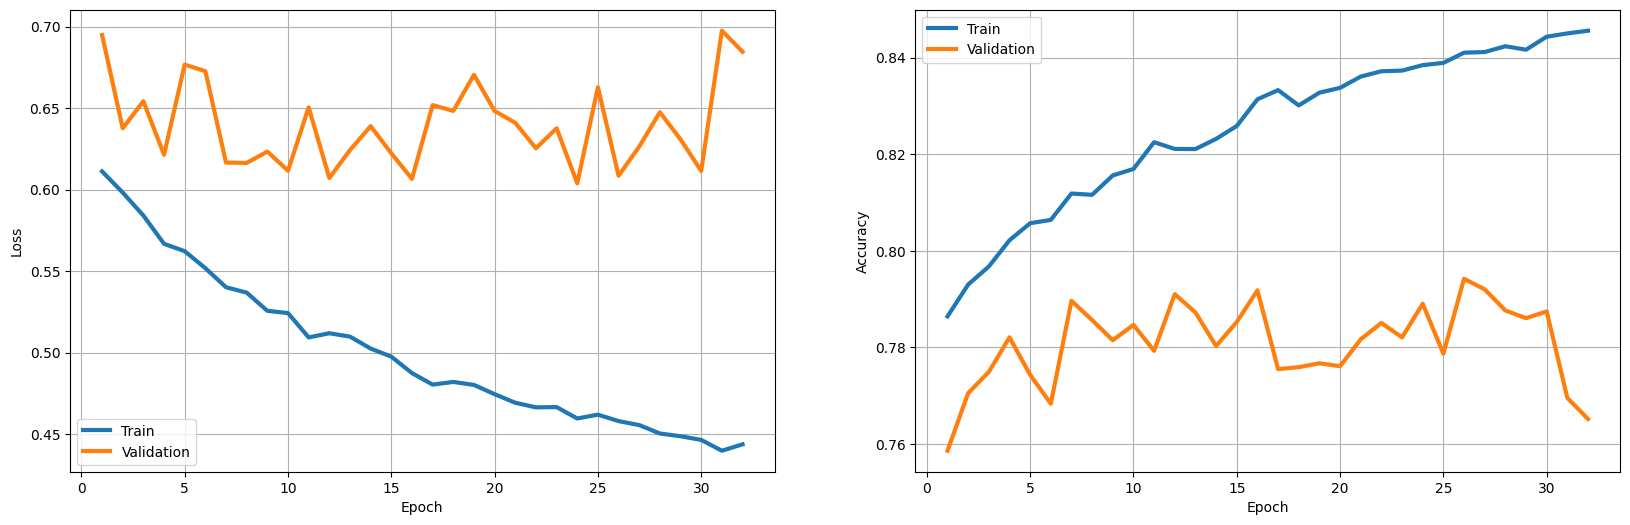

In [ ]:
N_EPOCHS = 32
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model2,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    model_name='findsfal_mlp.pt')

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)
model_testing(model2, test_iterator, criterion, device, model_name='finaldsf_mlp.pt')

In [ ]:
def get_net():
    resnet = torchvision.models.resnet34(pretrained=True)

    # Substitute the FC output layer
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

In [ ]:
net = get_net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


In [ ]:
lr, weight_decay, epochs = 1e-5, 5e-4, 20
criterion = torch.nn.CrossEntropyLoss()
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)

In [ ]:
print(net.fc.parameters())

<generator object Module.parameters at 0x79e02197e030>


In [ ]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
N_EPOCHS = 32
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    net,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    model_name='net')

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)
model_testing(net, test_iterator, criterion, device, model_name='net')


Epoch: 1/32 -- Epoch Time: 475.47 s
---------------------------------
Train -- Loss: 0.821, Acc: 71.59%
Val -- Loss: 0.357, Acc: 88.14%

Epoch: 2/32 -- Epoch Time: 469.24 s
---------------------------------
Train -- Loss: 0.408, Acc: 85.84%
Val -- Loss: 0.255, Acc: 91.38%

Epoch: 3/32 -- Epoch Time: 475.40 s
---------------------------------
Train -- Loss: 0.303, Acc: 89.51%
Val -- Loss: 0.224, Acc: 92.32%

Epoch: 4/32 -- Epoch Time: 474.44 s
---------------------------------
Train -- Loss: 0.248, Acc: 91.58%
Val -- Loss: 0.192, Acc: 93.61%

Epoch: 5/32 -- Epoch Time: 474.56 s
---------------------------------
Train -- Loss: 0.205, Acc: 92.92%
Val -- Loss: 0.186, Acc: 93.79%

Epoch: 6/32 -- Epoch Time: 473.72 s
---------------------------------
Train -- Loss: 0.172, Acc: 94.18%
Val -- Loss: 0.178, Acc: 94.03%

Epoch: 7/32 -- Epoch Time: 475.81 s
---------------------------------
Train -- Loss: 0.153, Acc: 94.77%
Val -- Loss: 0.156, Acc: 94.43%

Epoch: 8/32 -- Epoch Time: 474.74 s
----

KeyboardInterrupt: ignored

In [ ]:
model_testing(net, test_iterator, criterion, device, model_name='net')

Test -- Loss: 0.162, Acc: 95.30 %
